# BraTS 2021 Preprocessing Demo

Demonstrates bias field correction, denoising, and registration on 3 demo cases.

In [1]:
import os
import numpy as np
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path

DATA_ROOT = Path('/workspace/DataChallenge/data/BraTS2021_Training_Data')
OUT_ROOT = Path('/workspace/brats-biohub/outputs')

DEMO_IDS = ['BraTS2021_00000', 'BraTS2021_00002', 'BraTS2021_00003']
MODALITIES = ['flair', 't1', 't1ce', 't2']

def load_sitk(path):
    return sitk.ReadImage(str(path), sitk.sitkFloat32)

def sitk_to_np(img):
    return sitk.GetArrayFromImage(img)

def get_mid_slice(arr):
    return arr[arr.shape[0] // 2]

print(f'Demo cases: {DEMO_IDS}')
print(f'Data root: {DATA_ROOT}')
print(f'Cases found: {len(list(DATA_ROOT.iterdir()))}')

Demo cases: ['BraTS2021_00000', 'BraTS2021_00002', 'BraTS2021_00003']
Data root: /workspace/DataChallenge/data/BraTS2021_Training_Data
Cases found: 1252


## 1. Bias Field Correction (N4ITK)

N4ITK corrects low-frequency intensity non-uniformity (bias field) caused by MRI inhomogeneities.

In [2]:
def n4_bias_field_correction(image, mask=None, shrink_factor=4, num_iterations=[50, 50, 30, 20]):
    """Apply N4ITK bias field correction."""
    # Shrink for speed
    shrunk = sitk.Shrink(image, [shrink_factor] * image.GetDimension())
    if mask is None:
        mask = sitk.OtsuThreshold(shrunk, 0, 1, 200)
    else:
        mask = sitk.Shrink(mask, [shrink_factor] * mask.GetDimension())
    
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations(num_iterations)
    corrector.SetConvergenceThreshold(1e-6)
    corrected_shrunk = corrector.Execute(shrunk, mask)
    
    # Get the bias field and apply to full-res
    log_bias = corrector.GetLogBiasFieldAsImage(image)
    corrected = image / sitk.Exp(log_bias)
    return corrected, sitk.Exp(log_bias)

# Run on demo cases (t1ce modality)
bias_results = {}
for sid in DEMO_IDS:
    fpath = DATA_ROOT / sid / f'{sid}_t1ce.nii.gz'
    print(f'Processing {sid} ...', end=' ')
    img = load_sitk(fpath)
    corrected, bias_field = n4_bias_field_correction(img)
    
    # Save
    out_dir = OUT_ROOT / 'bias_field'
    sitk.WriteImage(corrected, str(out_dir / f'{sid}_t1ce_n4.nii.gz'))
    
    bias_results[sid] = {
        'original': sitk_to_np(img),
        'corrected': sitk_to_np(corrected),
        'bias_field': sitk_to_np(bias_field)
    }
    print('done')

print(f'\nSaved corrected images to {OUT_ROOT / "bias_field"}')

Processing BraTS2021_00000 ... 

done
Processing BraTS2021_00002 ... 

done
Processing BraTS2021_00003 ... 

done

Saved corrected images to /workspace/brats-biohub/outputs/bias_field


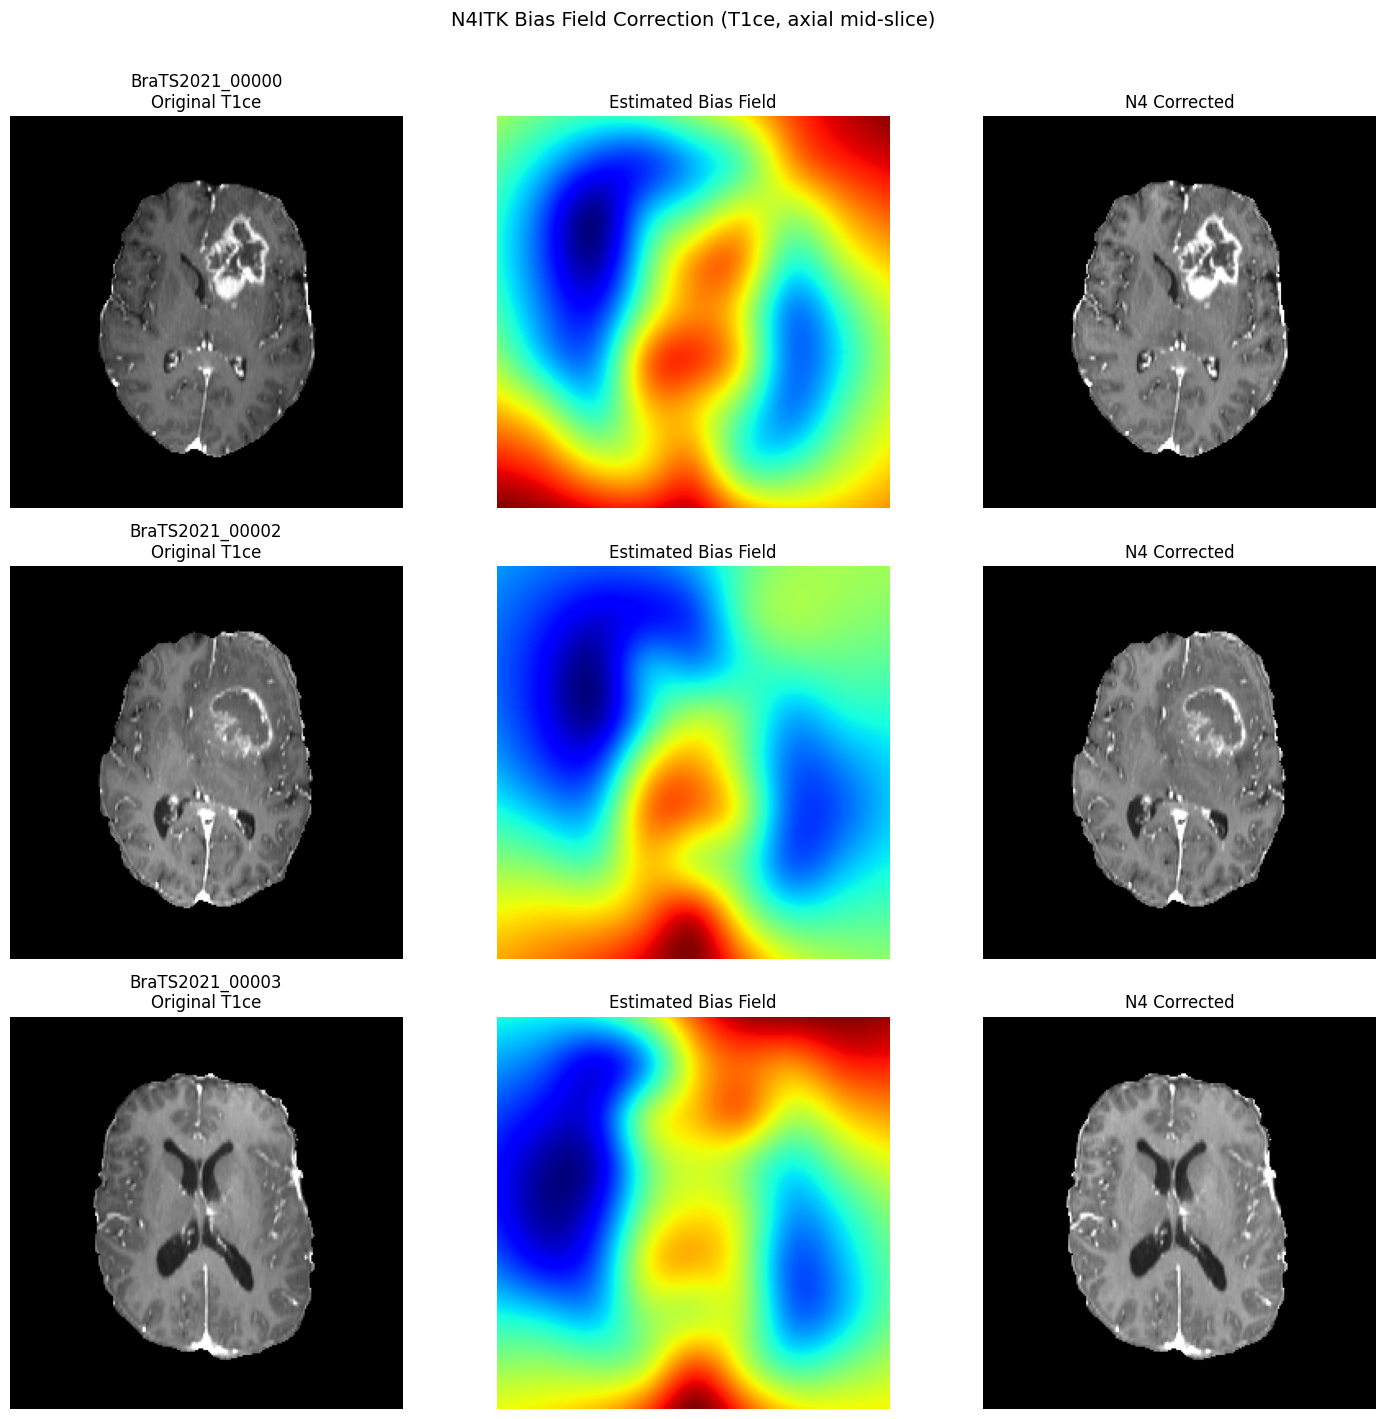

Figure saved.


In [3]:
# Visualize bias field correction results
fig, axes = plt.subplots(3, 3, figsize=(15, 14))
for i, sid in enumerate(DEMO_IDS):
    r = bias_results[sid]
    orig_sl = get_mid_slice(r['original'])
    corr_sl = get_mid_slice(r['corrected'])
    bias_sl = get_mid_slice(r['bias_field'])
    
    vmax = np.percentile(orig_sl[orig_sl > 0], 99) if orig_sl.max() > 0 else 1
    axes[i, 0].imshow(orig_sl, cmap='gray', vmin=0, vmax=vmax)
    axes[i, 0].set_title(f'{sid}\nOriginal T1ce')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(bias_sl, cmap='jet')
    axes[i, 1].set_title('Estimated Bias Field')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(corr_sl, cmap='gray', vmin=0, vmax=vmax)
    axes[i, 2].set_title('N4 Corrected')
    axes[i, 2].axis('off')

plt.suptitle('N4ITK Bias Field Correction (T1ce, axial mid-slice)', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(str(OUT_ROOT / 'bias_field' / 'bias_field_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved.')

## 2. Denoising (Curvature Flow)

Curvature flow smooths the image while preserving edges — suitable for MRI denoising.

In [4]:
def curvature_flow_denoise(image, timestep=0.0625, num_iterations=5):
    """Apply curvature flow denoising."""
    denoised = sitk.CurvatureFlow(
        image1=image,
        timeStep=timestep,
        numberOfIterations=num_iterations
    )
    return denoised

# Run on demo cases (flair modality)
denoise_results = {}
for sid in DEMO_IDS:
    fpath = DATA_ROOT / sid / f'{sid}_flair.nii.gz'
    print(f'Denoising {sid} ...', end=' ')
    img = load_sitk(fpath)
    denoised = curvature_flow_denoise(img)
    
    out_dir = OUT_ROOT / 'denoised'
    sitk.WriteImage(denoised, str(out_dir / f'{sid}_flair_denoised.nii.gz'))
    
    denoise_results[sid] = {
        'original': sitk_to_np(img),
        'denoised': sitk_to_np(denoised)
    }
    print('done')

print(f'\nSaved denoised images to {OUT_ROOT / "denoised"}')

Denoising BraTS2021_00000 ... 

done
Denoising BraTS2021_00002 ... 

done
Denoising BraTS2021_00003 ... 

done

Saved denoised images to /workspace/brats-biohub/outputs/denoised


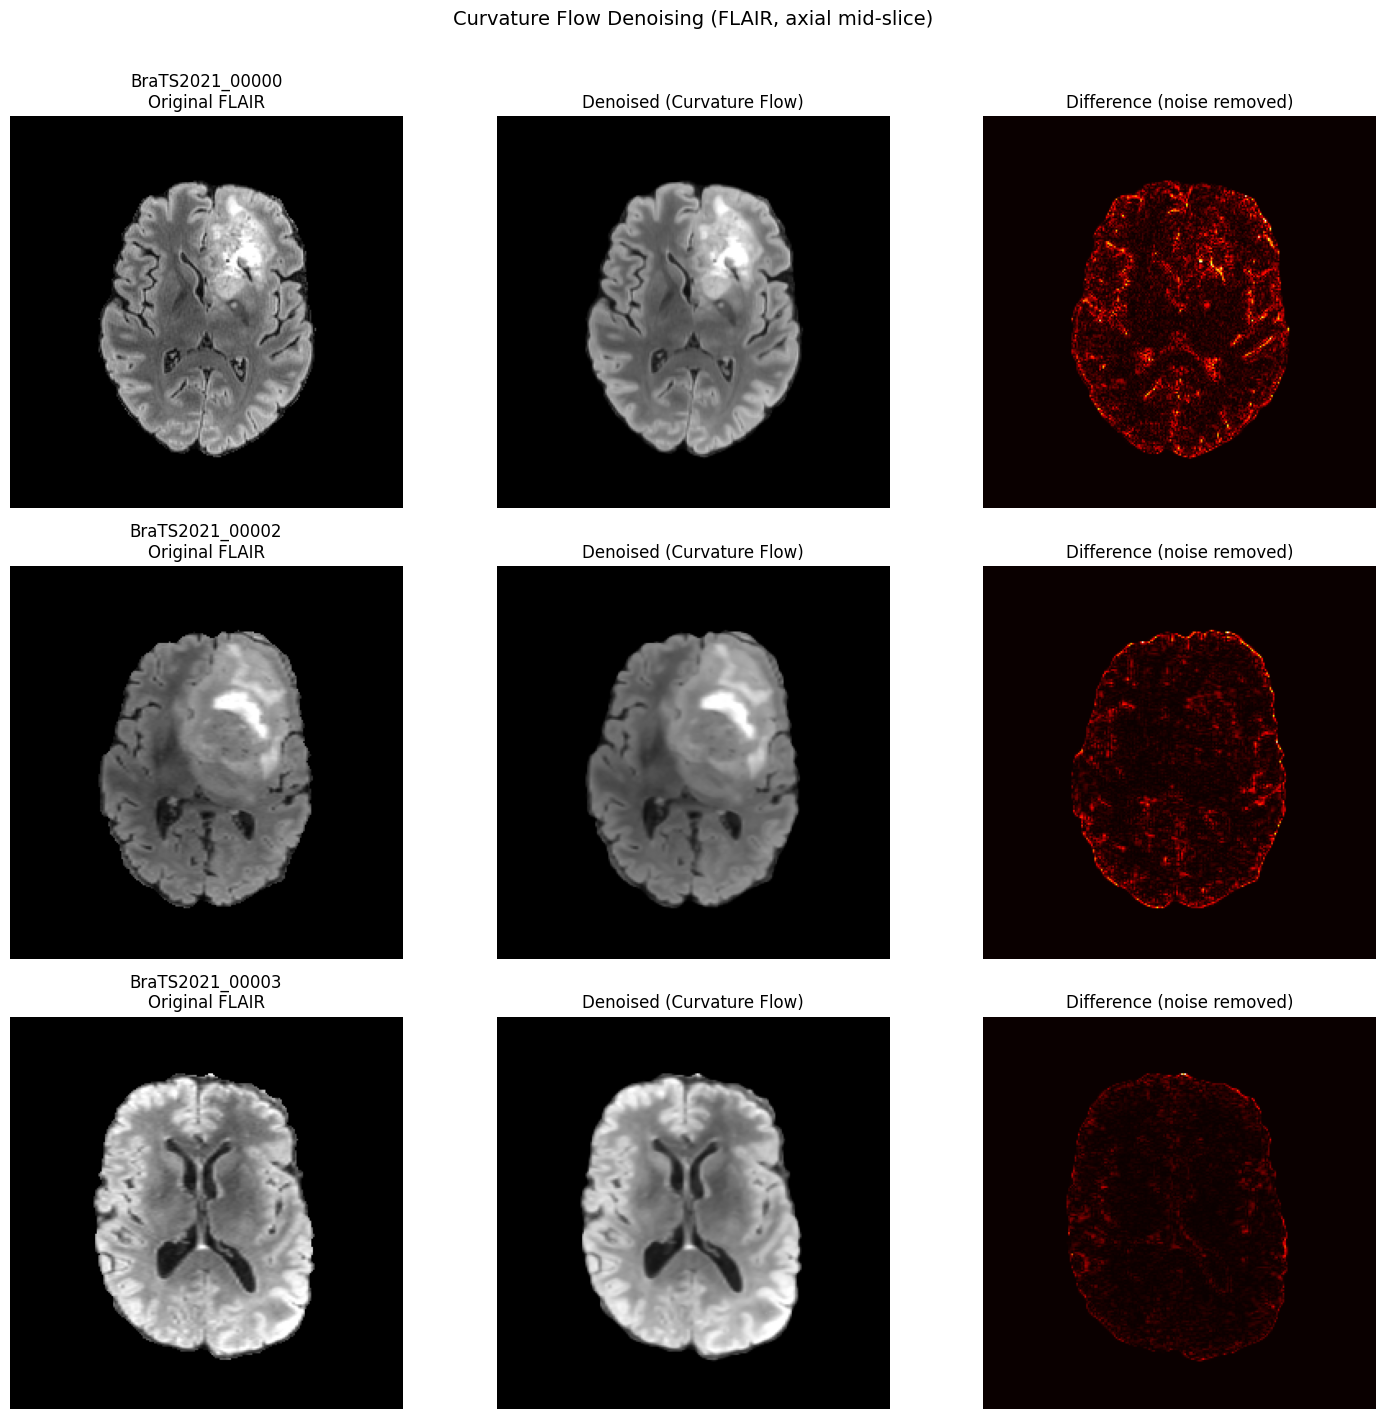

Figure saved.


In [5]:
# Visualize denoising results
fig, axes = plt.subplots(3, 3, figsize=(15, 14))
for i, sid in enumerate(DEMO_IDS):
    r = denoise_results[sid]
    orig_sl = get_mid_slice(r['original'])
    den_sl = get_mid_slice(r['denoised'])
    diff_sl = np.abs(orig_sl - den_sl)
    
    vmax = np.percentile(orig_sl[orig_sl > 0], 99) if orig_sl.max() > 0 else 1
    axes[i, 0].imshow(orig_sl, cmap='gray', vmin=0, vmax=vmax)
    axes[i, 0].set_title(f'{sid}\nOriginal FLAIR')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(den_sl, cmap='gray', vmin=0, vmax=vmax)
    axes[i, 1].set_title('Denoised (Curvature Flow)')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(diff_sl, cmap='hot')
    axes[i, 2].set_title('Difference (noise removed)')
    axes[i, 2].axis('off')

plt.suptitle('Curvature Flow Denoising (FLAIR, axial mid-slice)', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(str(OUT_ROOT / 'denoised' / 'denoising_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved.')

## 3. Registration Demo

Demonstrate rigid registration of T1 to T1ce (inter-modality alignment) for one case.

In [6]:
def register_rigid(fixed, moving):
    """Rigid registration of moving to fixed image."""
    reg = sitk.ImageRegistrationMethod()
    reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.1)
    reg.SetInterpolator(sitk.sitkLinear)
    
    initial_transform = sitk.CenteredTransformInitializer(
        fixed, moving, sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )
    reg.SetInitialTransform(initial_transform, inPlace=False)
    
    reg.SetOptimizerAsGradientDescent(
        learningRate=1.0, numberOfIterations=200,
        convergenceMinimumValue=1e-6, convergenceWindowSize=10
    )
    reg.SetOptimizerScalesFromPhysicalShift()
    
    # Multi-resolution
    reg.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    reg.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    reg.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    final_transform = reg.Execute(fixed, moving)
    
    resampled = sitk.Resample(
        moving, fixed, final_transform,
        sitk.sitkLinear, 0.0, moving.GetPixelID()
    )
    return resampled, final_transform

# Register T1 -> T1ce for first demo case
sid = DEMO_IDS[0]
print(f'Registering T1 -> T1ce for {sid} ...')

fixed = load_sitk(DATA_ROOT / sid / f'{sid}_t1ce.nii.gz')
moving = load_sitk(DATA_ROOT / sid / f'{sid}_t1.nii.gz')

registered, transform = register_rigid(fixed, moving)

sitk.WriteImage(registered, str(OUT_ROOT / 'registration' / f'{sid}_t1_to_t1ce.nii.gz'))
print(f'Registration complete. Transform:\n{transform}')

Registering T1 -> T1ce for BraTS2021_00000 ...


Registration complete. Transform:
itk::simple::CompositeTransform
 CompositeTransform (0xbb7c650)
   RTTI typeinfo:   itk::CompositeTransform<double, 3u>
   Reference Count: 1
   Modified Time: 3482620
   Debug: Off
   Object Name: 
   Observers: 
     none
   TransformQueue: 
   >>>>>>>>>
   Euler3DTransform (0x3bd81a0)
     RTTI typeinfo:   itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 3482466
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.999998 -0.00154562 0.00134324 
       0.00154474 0.999999 0.000653753 
       -0.00134425 -0.000651676 0.999999 
     Offset: [-2.87194, -0.714364, 0.853289]
     Center: [119.5, -119.5, 77]
     Translation: [-2.58406, -0.47926, 0.77044]
     Inverse: 
       0.999998 0.00154474 -0.00134425 
       -0.00154562 0.999999 -0.000651676 
       0.00134324 0.000653753 0.999999 
     Singular: 0
     AngleX: -0.000651676
     AngleY: 0.00134425
     AngleZ: 0.00154562
     ComputeZYX: Of

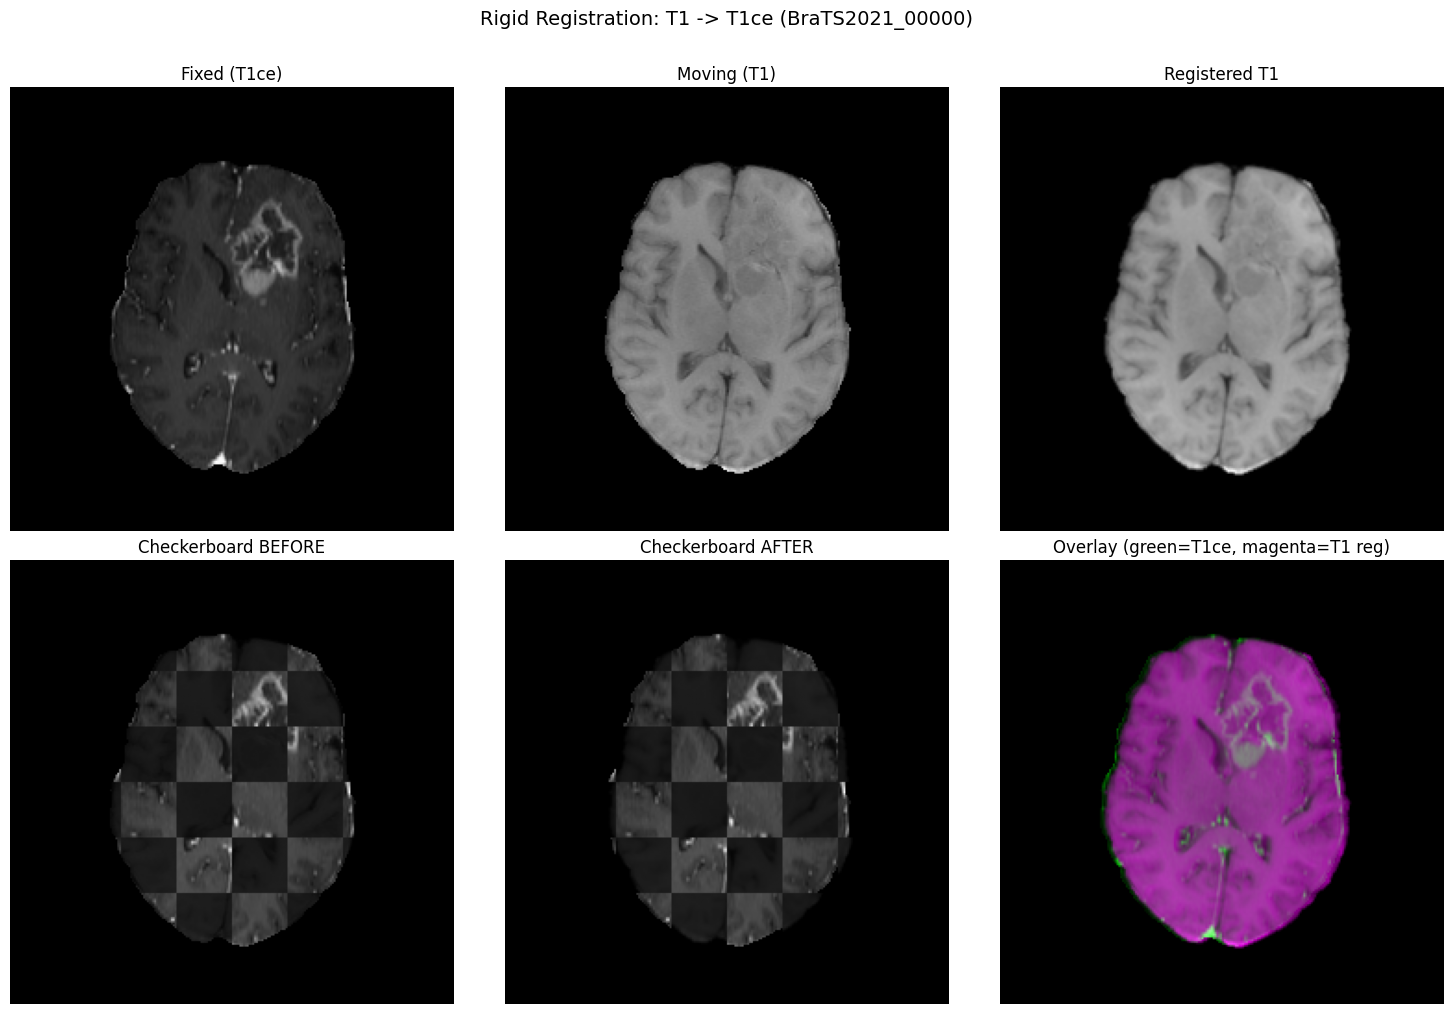

Figure saved.


In [7]:
# Visualize registration: checkerboard + overlay
fixed_np = sitk_to_np(fixed)
moving_np = sitk_to_np(moving)
registered_np = sitk_to_np(registered)

sl = fixed_np.shape[0] // 2

def normalize_slice(s):
    s = s.astype(float)
    if s.max() > s.min():
        return (s - s.min()) / (s.max() - s.min())
    return s

f_sl = normalize_slice(fixed_np[sl])
m_sl = normalize_slice(moving_np[sl])
r_sl = normalize_slice(registered_np[sl])

# Checkerboard
checker_before = sitk_to_np(sitk.CheckerBoard(fixed, moving, [8, 8, 1]))[sl]
checker_after = sitk_to_np(sitk.CheckerBoard(fixed, registered, [8, 8, 1]))[sl]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(f_sl, cmap='gray')
axes[0, 0].set_title('Fixed (T1ce)')
axes[0, 0].axis('off')

axes[0, 1].imshow(m_sl, cmap='gray')
axes[0, 1].set_title('Moving (T1)')
axes[0, 1].axis('off')

axes[0, 2].imshow(r_sl, cmap='gray')
axes[0, 2].set_title('Registered T1')
axes[0, 2].axis('off')

axes[1, 0].imshow(checker_before, cmap='gray')
axes[1, 0].set_title('Checkerboard BEFORE')
axes[1, 0].axis('off')

axes[1, 1].imshow(checker_after, cmap='gray')
axes[1, 1].set_title('Checkerboard AFTER')
axes[1, 1].axis('off')

# Overlay: fixed=green, registered=magenta
overlay = np.zeros((*f_sl.shape, 3))
overlay[..., 0] = r_sl  # red
overlay[..., 1] = f_sl  # green
overlay[..., 2] = r_sl  # blue -> magenta for registered
axes[1, 2].imshow(overlay)
axes[1, 2].set_title('Overlay (green=T1ce, magenta=T1 reg)')
axes[1, 2].axis('off')

plt.suptitle(f'Rigid Registration: T1 -> T1ce ({sid})', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(str(OUT_ROOT / 'registration' / 'registration_demo.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved.')